# Generating chunks from input data
This notebook shows the process to generate chunks of given shape (time, latitude, longitude) from data of shape (time, latitude, longitude, channels). This script takes also into account shapes of chunks that are not multiple of the input by generating extra chunks and concatenating the remain left. It also contains the function to rebuild the data from the generated chunks.

In [7]:
import xarray as xr

In [8]:
data_x = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data = data_x.sel(time=slice('1980-01-14T16:00:00','1980-01-15T23:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
data = data.transpose('time', 'latitude', 'longitude', 'level')
data = data['t'].values
data.shape

data = data[0:16,0:720,0:720,:]
data.shape

(16, 720, 720, 1)

In [9]:
import numpy as np

def chunk_data(data, size):
    """
    Chunks data into (N, time, lat, lon, channels)
    Args:
    ===================
    data: 4D - Numpy array (time, lat, lon, channels).
    size: (t, lat, lon) of one chunk.
    
    Returns Numpy array with size (N-chunks, time, lat, long, channels)
    """
    assert (data.shape[0] >= size[0] and data.shape[1] >= size[1] and data.shape[2] >= size[2]), 'Chunks size cannot be larger than the data size.'
    
    chunk_num = (int(np.ceil(data.shape[0]/size[0]) ), int(np.ceil(data.shape[1]/size[1])), int(np.ceil(data.shape[2] /size[2])))
    
    length = int(np.prod(chunk_num )) 
    
    x = np.stack([calculateValues(data, i, size, chunk_num) for i in range(length)], axis = 0)
    
    return x

def calculateValues(data, i, size, chunk_num):
    tix, latix, lonix = np.unravel_index(i, chunk_num)

    if (tix*size[0] + size[0]) > data.shape[0]:
        out = data[-size[0]:, latix*size[1]: latix*size[1] + size[1], lonix*size[2]: lonix*size[2] + size[2]]
        
        if ((latix*size[1] + size[1]) > data.shape[1]) and ((lonix*size[2] + size[2]) > data.shape[2]):
            out = data[-size[0]:, -size[1]:, -size[2]:]
        elif(latix*size[1] + size[1]) > data.shape[1]:
            out = data[-size[0]:, -size[1]: ,  lonix*size[2]: lonix*size[2] + size[2]]
        elif(lonix*size[2] + size[2]) > data.shape[2]:
            out = data[-size[0]:, latix*size[1]: latix*size[1] + size[1], -size[2]:]
        
    elif (latix*size[1] + size[1]) > data.shape[1]:
        out = data[tix*size[0]: tix*size[0] + size[0], -size[1]: , lonix*size[2]: lonix*size[2] + size[2]]
        if(lonix*size[2] + size[2]) > data.shape[2]:
            out = data[tix*size[0]: tix*size[0] + size[0], -size[1]: , -size[2]:]
        
    elif (lonix*size[2] + size[2]) > data.shape[2]:
        out = data[tix*size[0]: tix*size[0] + size[0], latix*size[1]: latix*size[1] + size[1], -size[2]:]

    else:
        out = data[tix*size[0]: tix*size[0] + size[0], latix*size[1]: latix*size[1] + size[1], lonix*size[2]: lonix*size[2] + size[2]]
        
    return out

In [10]:
res = chunk_data(data, (16, 48, 48))
res.shape

(225, 16, 48, 48, 1)

# Merging chunks to generate the input

In [11]:
def merge_data(data, size):
    """
    Merges data into (time, lat, lon, channels)
    Args:
    =======================
    data: 5D - Numpy array.(N-chunks, time, lat, lon, channels)
    size: (time, lat, lon, attr.) size of the output data.
    
    Returns complete data (t, lat, long, channels)
    """
    
    chunks_size = data.shape[1:4]
    num_chunks = (int(np.ceil(size[0]/chunks_size[0]) ), int(np.ceil(size[1]/chunks_size[1])), int(np.ceil(size[2] /chunks_size[2])))
    x = np.concatenate([ np.concatenate([np.concatenate(
        [ select_chunk(data,i,j,k,num_chunks, chunks_size, size)
        for i in range(num_chunks[2])], axis=2)for j in range(num_chunks[1])], axis = 1)
                         for k in range(num_chunks[0])], axis = 0)
    return x
     
def select_chunk(data, i, j, k, num_chunks, chunks_size, size):

    if ((i * chunks_size[2] +chunks_size[2]) > size[2]):
        mn = chunks_size[2] - ((i * chunks_size[2] + chunks_size[2])- size[2])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][:,:,-mn:]
        
        if ((j * chunks_size[1] + chunks_size[1])  > size[1]):
            mn = chunks_size[1] - ((j * chunks_size[1] + chunks_size[1]) - size[1])
            out = out[:,-mn:,:]
            
        if ((k * chunks_size[0]+ chunks_size[0]) >size[0]):
            mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
            out = out[-mn:,:,:]  
        
            
    elif ((j * chunks_size[1] + chunks_size[1])  > size[1]):
        mn = chunks_size[1] - ((j * chunks_size[1] + chunks_size[1]) - size[1])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][:,-mn:,:]
        if ((k * chunks_size[0]+ chunks_size[0]) >size[0]):
            mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
            out = out[-mn:,:,:]
            
    elif ((k * chunks_size[0]+ chunks_size[0]) > size[0]):
        mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][-mn:,:,:]


    else:
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i]
    return out





In [12]:
out = merge_data(res, data.shape)

In [13]:
np.all(out == data) #Checking if the merged data corresponds to the input data.

True

# Testing overlapping chunks

In [14]:
import xarray as xr
import numpy as np
from lossycomp.plots import single_plot

data_x = xr.open_mfdataset('/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc', combine='by_coords')
data = data_x.sel(time=slice('1980-01-14T16:00:00','1980-01-15T23:00:00'),level = slice(978,1000), longitude=slice(-180,180), latitude=slice(90,-90))
data = data.transpose('time', 'latitude', 'longitude', 'level')
data = data['t'].values
data.shape

#data = data[0:16,0:721,0:72,:]
data.shape

(32, 721, 1440, 1)

(1, 32, 721, 1440, 1)


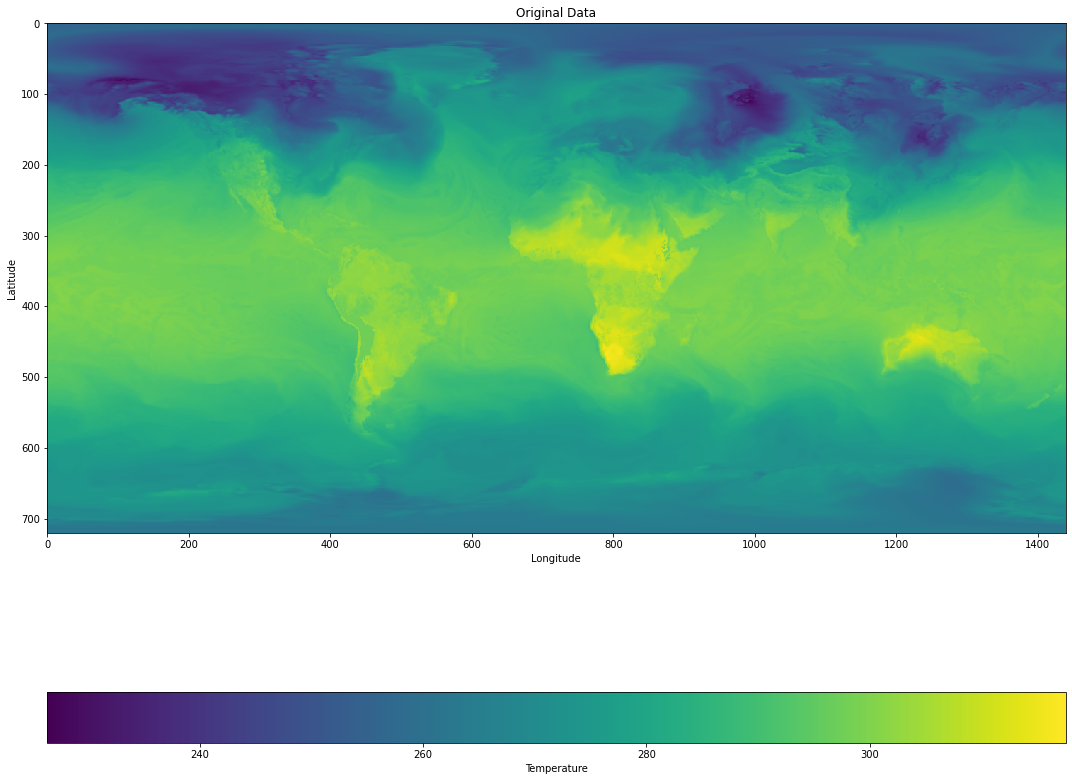

In [15]:
#data_r = np.expand_dims(data[:,:,:,0], axis=0)
data_r = np.expand_dims(data, axis=0)
#data_r = np.expand_dims(data_r, axis=4)
print(data_r.shape)
single_plot(data_r, 0, "Original Data", "Temperature", data_r[0,0].min(), data_r[0,0].max())

(1, 32, 721, 1416, 1)


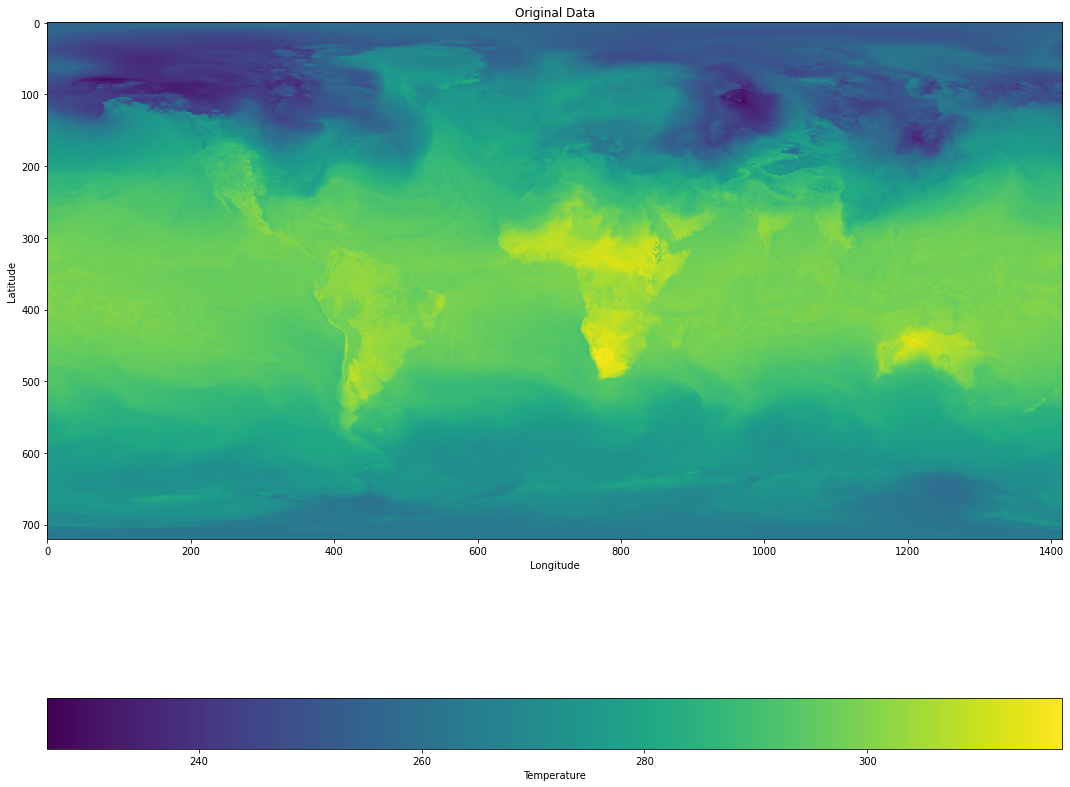

In [16]:
data_o = data_r[:, :, :, int(48/2):]
print(data_o.shape)
single_plot(data_o, 0, "Original Data", "Temperature", data_r[0,0].min(), data_r[0,0].max())

In [17]:
def chunk_data2(data, size):
    """
    Chunks data into (N, time, lat, lon, channels)
    Args:
    ===================
    data: 4D - Numpy array (time, lat, lon, channels).
    size: (t, lat, lon) of one chunk.
    
    Returns Numpy array with size (N-chunks, time, lat, long, channels)
    """
    assert (data.shape[0] >= size[0] and data.shape[1] >= size[1] and data.shape[2] >= size[2]), 'Chunks size cannot be larger than the data size.'
    
    chunk_num = (int(np.ceil(data.shape[0]/size[0]) ), int(np.floor(data.shape[1]/size[1])), int(np.floor(data.shape[2] /size[2])))
    
    length = int(np.prod(chunk_num)) 
    
    x = np.stack([calculateValues(data, i, size, chunk_num) for i in range(length)], axis = 0)
    
    return x

def calculateValues(data, i, size, chunk_num):
    tix, latix, lonix = np.unravel_index(i, chunk_num)

    if (tix*size[0] + size[0]) > data.shape[0]:
        out = data[-size[0]:, latix*size[1]: latix*size[1] + size[1], lonix*size[2]: lonix*size[2] + size[2]]
        
        if ((latix*size[1] + size[1]) > data.shape[1]) and ((lonix*size[2] + size[2]) > data.shape[2]):
            out = data[-size[0]:, -size[1]:, -size[2]:]
        elif(latix*size[1] + size[1]) > data.shape[1]:
            out = data[-size[0]:, -size[1]: ,  lonix*size[2]: lonix*size[2] + size[2]]
        elif(lonix*size[2] + size[2]) > data.shape[2]:
            out = data[-size[0]:, latix*size[1]: latix*size[1] + size[1], -size[2]:]
        
    elif (latix*size[1] + size[1]) > data.shape[1]:
        out = data[tix*size[0]: tix*size[0] + size[0], -size[1]: , lonix*size[2]: lonix*size[2] + size[2]]
        if(lonix*size[2] + size[2]) > data.shape[2]:
            out = data[tix*size[0]: tix*size[0] + size[0], -size[1]: , -size[2]:]
        
    elif (lonix*size[2] + size[2]) > data.shape[2]:
        out = data[tix*size[0]: tix*size[0] + size[0], latix*size[1]: latix*size[1] + size[1], -size[2]:]

    else:
        out = data[tix*size[0]: tix*size[0] + size[0], latix*size[1]: latix*size[1] + size[1], lonix*size[2]: lonix*size[2] + size[2]]
        
    return out

In [18]:
def merge_data2(data, size):
    """
    Merges data into (time, lat, lon, channels)
    Args:
    =======================
    data: 5D - Numpy array.(N-chunks, time, lat, lon, channels)
    size: (time, lat, lon, attr.) size of the output data.
    
    Returns complete data (t, lat, long, channels)
    """
    
    chunks_size = data.shape[1:4]
    num_chunks = (int(np.ceil(size[0]/chunks_size[0]) ), int(np.floor(size[1]/chunks_size[1])), int(np.floor(size[2] /chunks_size[2])))
    x = np.concatenate([ np.concatenate([np.concatenate(
        [ select_chunk(data,i,j,k,num_chunks, chunks_size, size)
        for i in range(num_chunks[2])], axis=2)for j in range(num_chunks[1])], axis = 1)
                         for k in range(num_chunks[0])], axis = 0)
    return x
     
def select_chunk(data, i, j, k, num_chunks, chunks_size, size):

    if ((i * chunks_size[2] +chunks_size[2]) > size[2]):
        mn = chunks_size[2] - ((i * chunks_size[2] + chunks_size[2])- size[2])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][:,:,-mn:]
        
        if ((j * chunks_size[1] + chunks_size[1])  > size[1]):
            mn = chunks_size[1] - ((j * chunks_size[1] + chunks_size[1]) - size[1])
            out = out[:,-mn:,:]
            
        if ((k * chunks_size[0]+ chunks_size[0]) >size[0]):
            mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
            out = out[-mn:,:,:]  
        
            
    elif ((j * chunks_size[1] + chunks_size[1])  > size[1]):
        mn = chunks_size[1] - ((j * chunks_size[1] + chunks_size[1]) - size[1])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][:,-mn:,:]
        if ((k * chunks_size[0]+ chunks_size[0]) >size[0]):
            mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
            out = out[-mn:,:,:]
            
    elif ((k * chunks_size[0]+ chunks_size[0]) > size[0]):
        mn = chunks_size[0] - ((k * chunks_size[0] + chunks_size[0]) - size[0])
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i][-mn:,:,:]


    else:
        out = data[(k*num_chunks[1]* num_chunks[2]) +  (j*num_chunks[2]) + i]
    return out



In [20]:
res = chunk_data(data, (16, 48, 48))
print(res.shape)
res2 = chunk_data2(data[:, int(48/2):,int(48/2):,:], (16, 48, 48))
print(res2.shape)

out = merge_data(res, data.shape)
out2 = merge_data2(res2, data[:, int(48/2):,int(48/2):,:].shape)

(960, 16, 48, 48, 1)
(812, 16, 48, 48, 1)


In [304]:
def apply_patches(data1, data2, chunk_size):
    chunks_size = 48
    num_chunks = int(np.floor(data1.shape[2]/chunks_size)) - 1
    
    print(num_chunks)
    
    ini = int(48/4)*3
    ini2 = int(48/4)*1
    
    width =  int(48/4)*2
    
    fin = ini + width
    fin2 = ini2 + width
    
    for i in range(num_chunks):
        if i == 0:
            data1[:,:,  ini: ini + width,:] = data2[:,:, ini2 : ini2 + width ,:]
            last_point =  ini + width
            last_point_2 = ini2 + width
        else:
            data1[:,:, last_point + width : last_point + width + width, :] = data2[:,:, last_point_2 + width : last_point_2 + width + width,:]
            last_point =  last_point + width + width
            last_point_2 = last_point_2 + width + width
    return data1


In [305]:
out_a = apply_patches(out, out2, data.shape)

29


(1, 32, 721, 1440, 1)


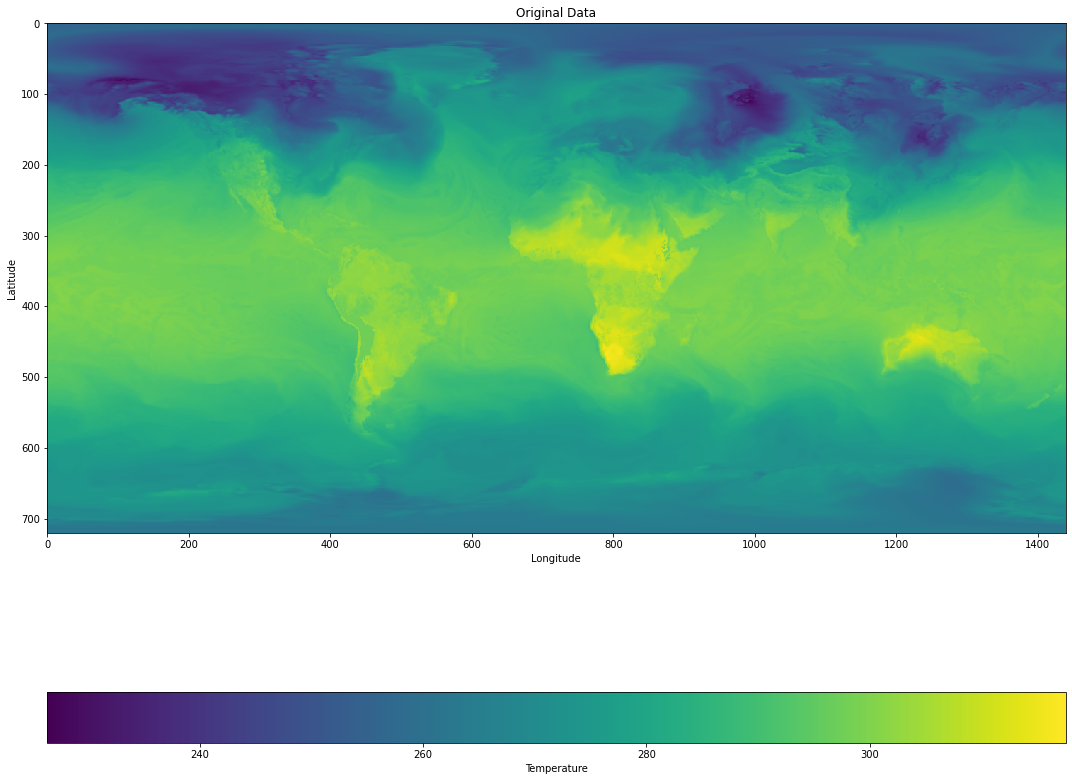

In [306]:
#data_r = np.expand_dims(data[:,:,:,0], axis=0)
out_r = np.expand_dims(out_a, axis=0)
#data_r = np.expand_dims(data_r, axis=4)
print(out_r.shape)
single_plot(out_r, 0, "Original Data", "Temperature", data_r[0,0].min(), data_r[0,0].max())

In [307]:
np.all(out == data)

True